In [103]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# Setup Paths
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

# Read Data
features_a = pd.read_pickle(pickle_path / "features_a.pkl")

# Split data
# Pull out labels
X = features_a.drop(['label', 'tot_chrgs'], axis=1)
y = features_a[['label']]

# Same features and splits used for all models
X_train, X_test, y_train, y_test = utils.scale_split_data(X, y)

In [144]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0).fit(X_train, np.ravel(y_train))  

print("Train Score: {:.3f}".format(LR.score(X_train,y_train)))
print("Test Score: {:.3f}".format(LR.score(X_test,y_test)))

Train Score: 0.861
Test Score: 0.843


### Intercept and Coefficient Evaluation

In [161]:
# Evaluate Intercept
intercept = LR.intercept_[0]
intercept_odds = np.exp(intercept)
intercept_prob = intercept_odds / (1 + intercept_odds)

print("INTERCEPT\n{:.1f}% probability of house having an EV".format(intercept_prob*100))

INTERCEPT
20.0% probability of house having an EV


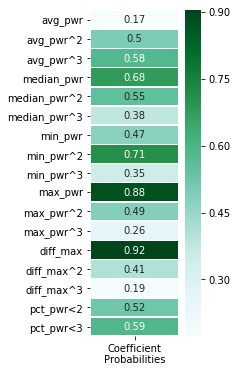

In [162]:
# Evaluate coefficients
analysis = pd.DataFrame(index=X_train.columns)
analysis['logodds'] = np.array(LR.coef_[0])
analysis['odds'] = np.exp(analysis['logodds'])
analysis['probs'] = analysis.odds / (1 + analysis.odds)

# Display as heatmap
f, ax = plt.subplots(figsize=(2, 6))
sns.heatmap(analysis.drop(['logodds', 'odds'], axis=1), 
            annot=True, cmap='BuGn', robust=True, 
            xticklabels=["Coefficient\nProbabilities"], 
            linewidths=.5
           )
f.savefig(fig_path / "A_coef_heatmap.png", 
          dpi=400,  bbox_inches='tight')

### ROC and PR Curves

In [107]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
y_true = y_test
y_scores = LR.predict(X_test)  
y_probs = LR.predict_proba(X_test)[:,1]

# ROC
auc = roc_auc_score(y_true, y_probs)
print("ROC AUC Score: {:.3f}".format(auc))
fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)

# Precision-Recall (PR) Curve
ap = average_precision_score(y_true, y_probs)  
print("Average Precision Score: {:.3f}".format(ap))
p, r, thresholds_pr = precision_recall_curve(y_true, y_probs)


ROC AUC Score: 0.901
Average Precision Score: 0.797


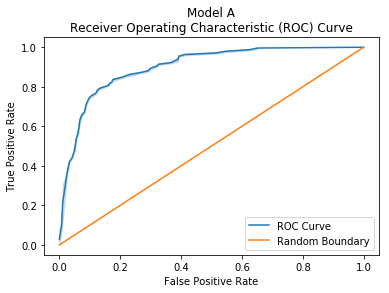

In [148]:
# Generate ROC Curve
sns.lineplot(x=fpr, y=tpr, markers='.')
sns.lineplot(x=[0,1], y=[0,1])
leg = plt.legend(('ROC Curve', 'Random Boundary'), frameon=True) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model A\nReceiver Operating Characteristic (ROC) Curve')

plt.savefig(fig_path / "A_ROC.png")
plt.show()

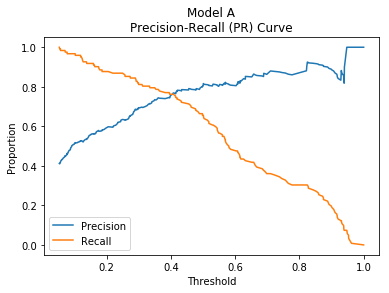

In [149]:
# Generate PR Curve
t = np.append(thresholds_pr, 1) 
if p.shape[0] != r.shape[0] != thresholds.shape[0]: 
    print("Error. Incorrect Shapes")
    print(p.shape[0], r.shape[0], t.shape[0])

sns.lineplot(t, p) 
sns.lineplot(t, r)
leg = plt.legend(('Precision', 'Recall'), frameon=True) 
plt.xlabel('Threshold') 
plt.ylabel('Proportion')
plt.title('Model A\nPrecision-Recall (PR) Curve');

plt.savefig(fig_path / "A_PR.png")
plt.show()